In [46]:
import numpy as np
from vivarium import Vivarium
from spatio_flux import PROCESS_DICT, TYPES_DICT, build_path

In [47]:
# TODO -- make a spatio-flux specific Vivarium with the the core preloaded
v = Vivarium(processes=PROCESS_DICT, types=TYPES_DICT)

In [48]:
v.get_types()

,Type
0,
1,length^3/time
2,current
3,length^3
4,length^2*mass/time^2
...,...
97,wires
98,printing_unit
99,substrate_role
100,tuple


In [49]:
# view the available processes
v.get_processes()

,Process
0,ram-emitter
1,composite
2,console-emitter
3,MinimalParticle
4,json-emitter
5,Particles
6,DynamicFBA
7,DiffusionAdvection


## dFBA alone

In [50]:
# inspect the config schema for the 'increase' process
v.process_schema('DynamicFBA')

'(model_file:string|kinetic_params:map[tuple[float,float]]|substrate_update_reactions:map[string]|biomass_identifier:string|bounds:map[bounds])'

In [51]:
# TODO - enable get_dataclass to work with the new process
# dfba_config  = v.get_dataclass('DynamicFBA')
dfba_config = {
    "model_file": "textbook",
    "kinetic_params": {
        "glucose": (0.5, 1),
        "acetate": (0.5, 2)},
    "substrate_update_reactions": {
        "glucose": "EX_glc__D_e",
        "acetate": "EX_ac_e"},
    "biomass_identifier": "biomass",
    "bounds": {
        "EX_o2_e": {"lower": -2, "upper": None},
        "ATPM": {"lower": 1, "upper": 1}
    }
}

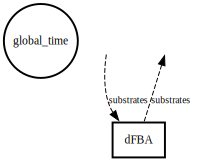

In [52]:
# add a dynamic FBA process called 'dFBA'
v.add_process(name="dFBA",
              process_id="DynamicFBA",
              config=dfba_config,
              )
v.diagram(dpi='70')

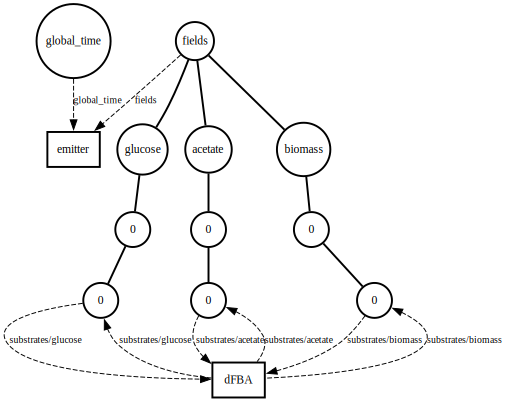

In [53]:
mol_ids = ["glucose", "acetate", "biomass"]
path=["fields"]
i = 0
j = 0

# for mol_id in mol_ids:
#     v.add_object(
#         name=mol_id,
#         path=path,
#         # type='array',
#         value=np.random.rand()
#     )

v.connect_process(
    process_name="dFBA",
    inputs={
            "substrates": {
                mol_id: build_path(path, mol_id, i, j)
                for mol_id in mol_ids}
        },
    outputs={
            "substrates": {
                mol_id: build_path(path, mol_id, i, j)
                for mol_id in mol_ids}
        }
)

# add an emitter to save results
v.add_emitter()

# TODO -- show_values does not work
v.diagram(dpi='70', show_values=True)

In [54]:
v.set_value(path = ['fields', 'glucose', 0, 0], value=10)
v.set_value(path = ['fields', 'biomass', 0, 0], value=0.1)
field = v.get_value(['fields'])
print(field)

{'glucose': {0: {0: 10}}, 'acetate': {0: {0: 0.0}}, 'biomass': {0: {0: 0.1}}}


In [55]:
# run the simulation for 10 time units
v.run(interval=60)

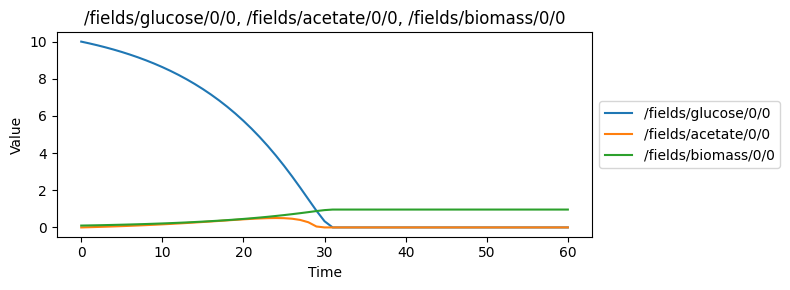

In [56]:
v.plot_timeseries(
    subplot_size=(8, 3),
    combined_vars=[
        [
            '/fields/glucose/0/0',
            '/fields/acetate/0/0',
            '/fields/biomass/0/0'
        ]
    ]
)

## Spatial Dynamic FBA

Adding dFBA[0,0] to ['fields', 'mol_id', 0, 0]



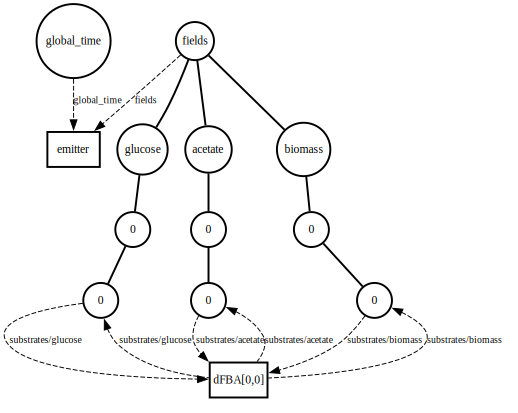

In [57]:
mol_ids = ["glucose", "acetate", "biomass"]
path=["fields"]
rows = 1
columns = 1

# make the vivarium
v2 = Vivarium(processes=PROCESS_DICT, types=TYPES_DICT)
for mol_id in mol_ids:
    v2.add_object(
        name=mol_id,
        path=path,
        type='array',
        value=np.random.rand(rows, columns)
    )

# add a dynamic FBA process at every location
for i in range(rows):
    for j in range(columns):
        dfba_name = f"dFBA[{i},{j}]"
        path_name = build_path(path, 'mol_id', i, j)
        print(f'Adding {dfba_name} to {path_name}\n')

        rewire_path= path  # [".."] + path

        # add a process for this location
        v2.add_process(
            name=dfba_name,
            process_id="DynamicFBA",
            # path=['species'],
            config=dfba_config,
        )
        v2.connect_process(
            process_name=dfba_name,
            # path=['species'],
            inputs={
                    "substrates": {
                        mol_id: build_path(rewire_path, mol_id, i, j)
                        for mol_id in mol_ids}
                },
            outputs={
                    "substrates": {
                        mol_id: build_path(rewire_path, mol_id, i, j)
                        for mol_id in mol_ids}
                }
        )

# add an emitter to save results
v2.add_emitter()

v2.diagram(dpi='70')

In [63]:
# change some initial values
# v2.set_value(path = ['fields', 'glucose', 0, 0], value=10)
# v2.set_value(path = ['fields', 'biomass', 0, 0], value=0.1)
field = v2.get_value(['fields'])
print(field)

{'glucose': {0: {0: np.float64(5.73702244844699)}}, 'acetate': {0: {0: np.float64(0.43593273101913493)}}, 'biomass': {0: {0: 0.4576769310911272}}}


In [64]:
v2.run(20)

In [65]:
timeseries = v2.get_timeseries()

In [66]:
timeseries

,/global_time,/fields/glucose/0/0,/fields/acetate/0/0,/fields/biomass/0/0
0,0.0,10.000000,0.000000,0.100000
1,1.0,9.904762,0.012108,0.107943
2,2.0,9.802006,0.025084,0.116515
3,3.0,9.691146,0.038979,0.125766
4,4.0,9.571550,0.053844,0.135747
5,5.0,9.442542,0.069731,0.146517
6,6.0,9.303393,0.086691,0.158137
7,7.0,9.153321,0.104770,0.170674
8,8.0,8.991487,0.124012,0.184199
9,9.0,8.816992,0.144454,0.198787


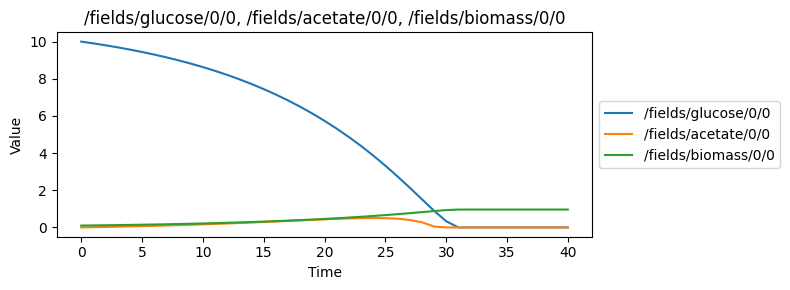

In [67]:
v2.plot_timeseries(
    subplot_size=(8, 3),
    combined_vars=[
        [
            '/fields/glucose/0/0',
            '/fields/acetate/0/0',
            '/fields/biomass/0/0'
        ]
    ]
)